In [11]:
import numpy as np
from datasets import get_dataset
import sys 
import matplotlib.pyplot as plt
from tiffwrapper import make_composite
from stedfm.decoders import get_decoder
import torch
import os
from stedfm.model_builder import get_base_model, get_pretrained_model_v2
from stedfm.configuration import Configuration 
from stedfm.DEFAULTS import BASE_PATH
import sys 
sys.path.insert(0, "../diffusion-experiments/")
from diffusion_models.diffusion.ddpm_lightning import DDPM 
from diffusion_models.diffusion.denoising.unet import UNet 


DATASET = "lioness"
MODEL = "mae-lightning-small"
WEIGHTS = "MAE_SMALL_STED"

diffusion_ckpt = os.path.join(BASE_PATH, "baselines", "DiffusionModels", "latent-guidance", WEIGHTS, "checkpoint-69.pth")
CHECKPOINT = "/home-local/Frederic/segmentation-baselines/mae-lightning-small/lioness/pretrained-MAE_SMALL_STED-46" 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
latent_encoder, model_config = get_pretrained_model_v2(
    name="mae-lightning-small",
    weights="MAE_SMALL_STED",
    path=None, 
    mask_ratio=0.0,
    pretrained=False,
    in_channels=1,
    as_classifier=True,
    blocks="all",
    num_classes=4
)

denoising_model = UNet(
    dim=64,
    channels=1,
    dim_mults=(1,2,4),
    cond_dim=model_config.dim,
    condition_type="latent",
    num_classes=4
)
diffusion_model = DDPM(
    denoising_model=denoising_model,
    timesteps=1000,
    beta_schedule="linear",
    condition_type="latent",
    latent_encoder=latent_encoder,
)

ckpt = torch.load(diffusion_ckpt)
diffusion_model.load_state_dict(ckpt["state_dict"])
diffusion_model.to(DEVICE)
_, _, test_dataset = get_dataset(name=DATASET, cfg=model_config)



mask_ratio 0.0
pretrained False
in_channels 1
blocks all
num_classes 4
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---
--- ViT case with none-ImageNet weights or from scratch ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---


Iterative sampling...: 100%|██████████| 1000/1000 [00:39<00:00, 25.43it/s]


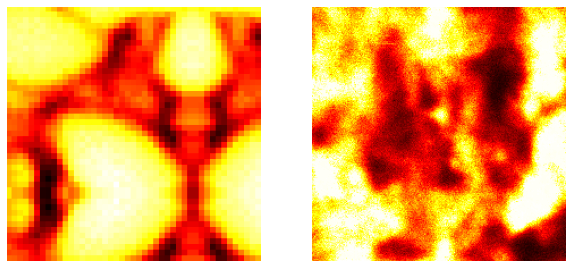

Iterative sampling...: 100%|██████████| 1000/1000 [00:39<00:00, 25.44it/s]


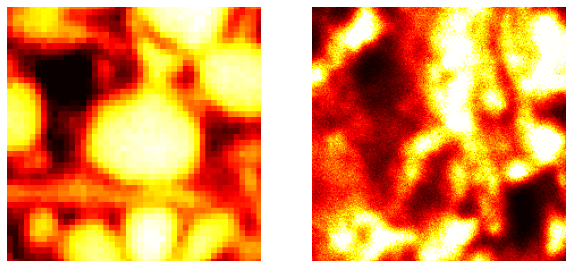

Iterative sampling...:  19%|█▉        | 189/1000 [00:07<00:31, 25.42it/s]


KeyboardInterrupt: 

In [13]:
import matplotlib.pyplot as plt
N = len(test_dataset)
indices = np.random.randint(0, N, size=10)
for idx in indices:
    img, _ = test_dataset[idx]
    img = img.unsqueeze(0).to(DEVICE)
    latent_code = latent_encoder.forward_features(img)
    sample = diffusion_model.p_sample_loop(shape=(img.shape[0], 1, img.shape[2], img.shape[3]), cond=latent_code, progress=True)
    sample_numpy = sample.squeeze().detach().cpu().numpy()
    img_numpy = img.squeeze().detach().cpu().numpy()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img_numpy, cmap="hot", vmin=0, vmax=1)
    axs[1].imshow(sample_numpy, cmap="hot", vmin=0, vmax=1)
    for ax in axs:
        ax.axis("off")
    plt.show()
    plt.close(fig)







